## SORBONNE UNIVERSITY - M2 DAC - 2023 - 2024
## RDFIA - Practical 2_C : Domain Adaptation
## Implemented by: Allaa BOUTALEB (21112734) & Samy NEHLIL (21113646)

<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

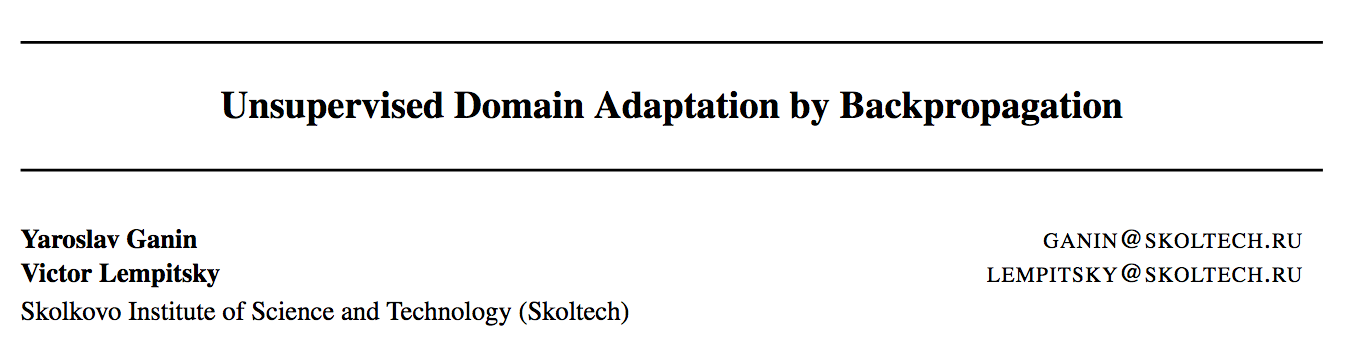

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Practical work Preparation.

In [ ]:
# Imports
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [ ]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2023-12-27 18:02:55--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2821 (2.8K) [text/plain]
Saving to: ‘mnistm.py’

mnistm.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2023-12-27 18:02:56 (34.3 MB/s) - ‘mnistm.py’ saved [2821/2821]



In [ ]:
from mnistm import create_mnistm

create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images


100%|██████████| 9912422/9912422 [00:00<00:00, 143541225.73it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19240103.85it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41695654.30it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21747178.96it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/content/mnistm.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bg_img = rand.choice(background_data)


Building train set...
Processing example 0
Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [ ]:
# Importing necessary library
import torchvision

# Load the MNIST dataset
# Setting 'train=True' to use the training data
# 'download=True' will download the data if it's not already present in the given directory ('.')
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255

# The pixel values of the MNIST dataset are in the range of 0 to 255.
# Dividing by 255 to normalize them to the range of 0 to 1.

# Calculating the mean of the pixel values
mean = mnist_pixels.mean().item()  # '.item()' converts it from a tensor to a Python scalar

# Calculating the standard deviation of the pixel values
std = mnist_pixels.std().item()  # '.item()' is used for the same reason as above

# Printing the calculated mean and standard deviation
print(f"Mean {mean} and Std {std}")

# As the MNIST images are grayscale, they have only one channel.
# However, many models expect input data in three channels (RGB format).
# To accommodate this, we are replicating the mean and std for three channels.
# This is a common practice when dealing with grayscale images for models expecting RGB input.
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [ ]:
# Defining a transformation pipeline for the MNIST dataset
transform = transforms.Compose([
  transforms.ToTensor(),  # Converts PIL Image or numpy.ndarray to tensor.
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,  # Replicates the image to 3 channels if it's grayscale.
  transforms.Normalize(mean, std)  # Normalizes the images using the calculated mean and std.
])

# Loading the MNIST dataset for training and testing
# Applying the defined transformation pipeline
mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

# Creating DataLoader for both training and testing datasets
# DataLoader provides an iterable over the dataset with given batch size and other properties.
source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

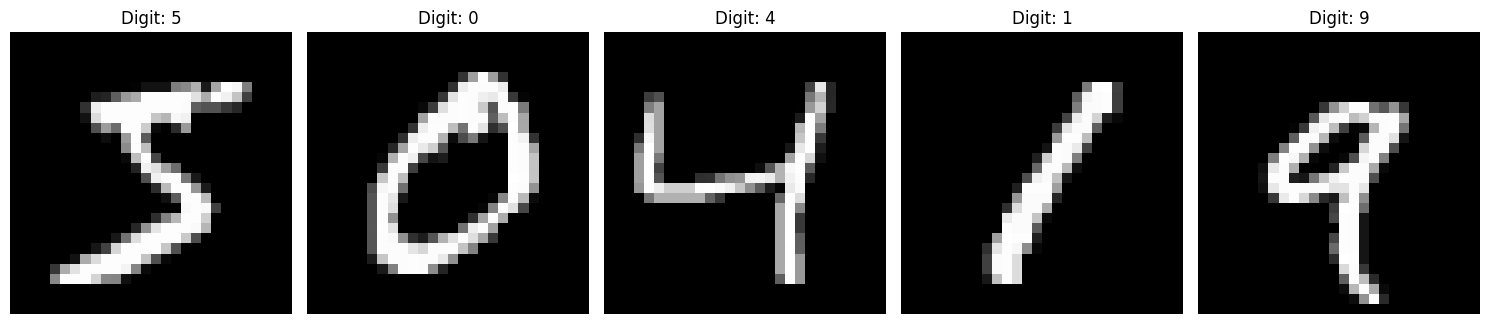

In [ ]:
plt.figure(figsize=(15, 5))

# Looping through the first 5 images in the MNIST training dataset
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    ax.axis('off')
    x, y = mnist_train[i]
    # Undoing the normalization and converting the image back to PIL format for display
    img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
    ax.imshow(img.numpy().astype(np.uint8), cmap='gray')
    ax.set_title(f"Digit: {y}", fontsize=12)

plt.tight_layout()
plt.show()

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [ ]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

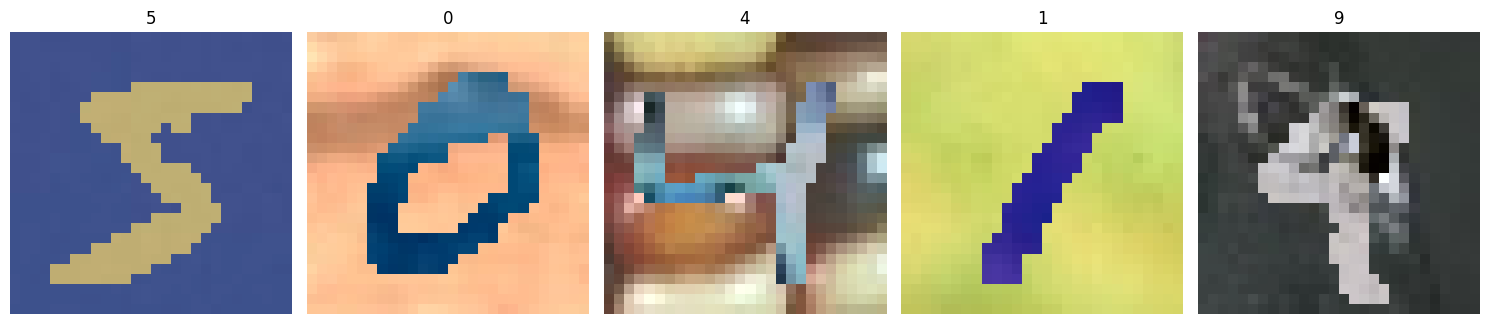

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))

  plt.tight_layout()
  plt.title(y)

### Naive Net.

Now, let's implement this basic network, whose figure is extracted from the paper. **Conceive your model so that convolutions do not reduce the spatial dimensions**:

For this we are going to use a padding p=2 for the kernel 5x5.

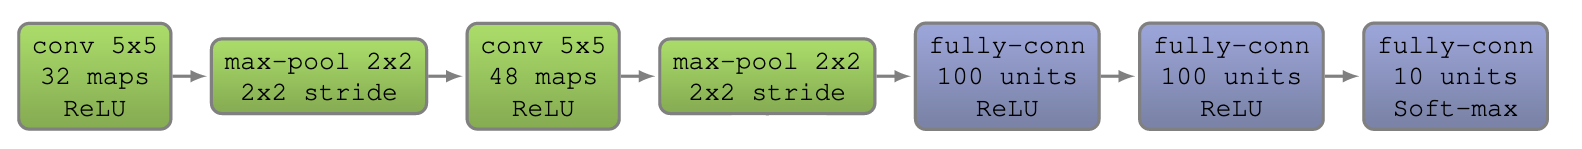

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NaiveNet(nn.Module):
    def __init__(self):
        super(NaiveNet, self).__init__()
        # Define the cnn part of the network
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),      # (32, 14, 14)
            nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2), # (48, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),      #  (48, 7, 7)
        )

        # The number of input features to the first fully connected layer will depend on the output size of the last MaxPool2d layer
        # The size can be computed as follows: ((W - F + 2P) / S) + 1, where W is the input dimension, F is the kernel size, P is the padding, and S is the stride
        # After two convolutions and poolings starting from 28x28, the size will be reduced to (28-4)/2, and then (12-4)/2, leading to 4x4 feature maps
        # So for 48 feature maps, we have 48 * 4 * 4 input features
        self.classif = nn.Sequential(
            nn.Linear(48 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            # nn.Softmax(dim=1)  # Use dim=1 to apply softmax to each row in the batch
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(start_dim=1)
        x = self.classif(x)
        return x

# Example usage:
# Initialize the network
net = NaiveNet()
# Create a random tensor to represent input images
input_tensor = torch.randn(2, 3, 28, 28)
# Pass the input tensor through the network to get the output
output = net(input_tensor)
# Print the output shape
print(output.shape)

torch.Size([2, 10])


In [ ]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [ ]:
from tqdm import tqdm

# Setting the number of epochs for training
epochs = 10

# Initializing the neural network and moving it to GPU
naive_net = NaiveNet().cuda()

# Setting up the optimizer with Stochastic Gradient Descent
optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

# Parameters for learning rate scheduling
mu0, alpha, beta = 0.01, 10, 0.75

# Setting up a learning rate scheduler
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

# Training loop
for epoch in range(epochs):
    train_loss = 0.0

    # Using tqdm for a progress bar
    progress_bar = tqdm(source_train_loader, desc=f'Epoch {epoch+1}/{epochs}')

    for x, y in progress_bar:
        # Moving data to GPU
        x, y = x.cuda(), y.cuda()

        # Zeroing the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = naive_net(x)

        # Computing loss
        loss = F.cross_entropy(logits, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulating the training loss
        train_loss += loss.item()

        # Updating the progress bar description
        progress_bar.set_postfix(loss=round(train_loss / len(source_train_loader), 5))

    # Step the scheduler
    scheduler.step()

    # Print learning rate
    lr = optimizer.param_groups[0]['lr']
    print(f'\tLearning rate after epoch {epoch+1}: {lr:.6f}')

# Evaluating the model
test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test Results - Loss: {test_loss:.5f}, Accuracy: {test_acc:.2f}%")

Epoch 1/10: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s, loss=0.385]


	Learning rate after epoch 1: 0.005946


Epoch 2/10: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s, loss=0.0596]


	Learning rate after epoch 2: 0.004387


Epoch 3/10: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s, loss=0.0418]


	Learning rate after epoch 3: 0.003536


Epoch 4/10: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s, loss=0.0336]


	Learning rate after epoch 4: 0.002991


Epoch 5/10: 100%|██████████| 469/469 [00:18<00:00, 24.94it/s, loss=0.0286]


	Learning rate after epoch 5: 0.002608


Epoch 6/10: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s, loss=0.025]


	Learning rate after epoch 6: 0.002324


Epoch 7/10: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s, loss=0.0223]


	Learning rate after epoch 7: 0.002102


Epoch 8/10: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s, loss=0.0202]


	Learning rate after epoch 8: 0.001925


Epoch 9/10: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s, loss=0.0184]


	Learning rate after epoch 9: 0.001778


Epoch 10/10: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s, loss=0.0169]


	Learning rate after epoch 10: 0.001656
Test Results - Loss: 0.03070, Accuracy: 98.90%


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [ ]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.532, test acc: 50.51


### DANN Architecture.

No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

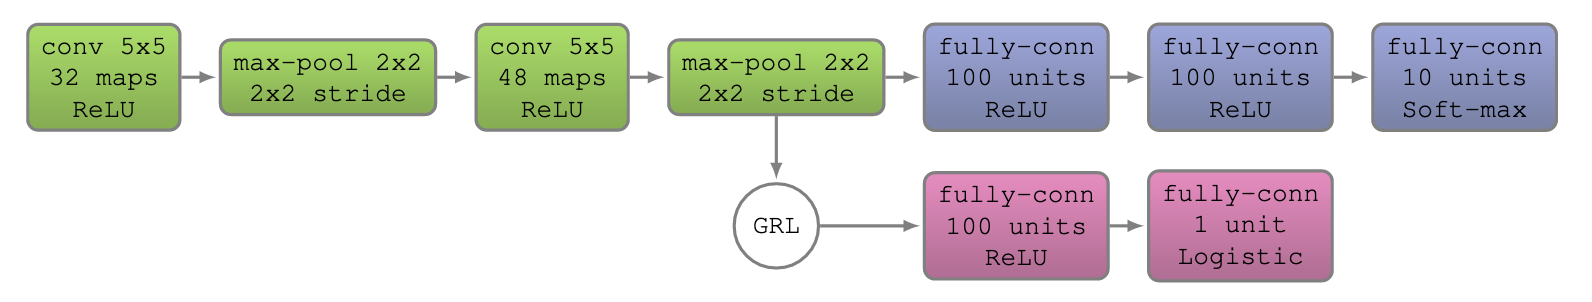

---

**Intuition behind the use of DANN:**

The key component in the `DANN` architecture, the Gradient Reversal Layer (`GRL`), is used to make the features extracted by the neural network domain-invariant.

---

**How it works:**

Feature Extractor (in green): This part of the network is responsible for extracting features from the input data. In the context of `MNIST` and `MNIST-M`, it would learn to extract features that are useful for classifying digits.

Domain Classifier (in pink): This branch tries to predict the domain of the input data (whether it's from `MNIST` or `MNIST-M`). Normally, it would get better over time at distinguishing between the two domains.

Gradient Reversal Layer (`GRL`): This is the core idea of the architecture. During the backpropagation phase, the GRL takes the gradient from the domain classifier and reverses it before it reaches the feature extractor.

Normal Gradient: Would update the feature extractor to make features more distinguishable between domains (making domain classification easier).

Reversed Gradient: Encourages the feature extractor to learn features that are not helpful for domain classification—essentially, features that are domain-agnostic.

---

**The intuition** is that by reversing the gradient, we're telling the feature extractor to do the opposite of what the domain classifier wants. Instead of learning to separate domains better, the feature extractor learns to produce features that are similar for both domains, focusing only on the information that's useful for digit classification (which is common to both domains).

This allows the network to generalize better to new domains (like `MNIST-M`), even if it has only been trained on the original domain (`MNIST`), because the features it relies on are not specific to either domain. In other words, it extracts the essence of what makes a digit a digit, regardless of the background or color schemes in the images.

---

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [ ]:
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, factor=-1):
        ctx.save_for_backward(torch.tensor(factor))
        return x

    @staticmethod
    def backward(ctx, grad):
        (factor,) = ctx.saved_tensors

        reversed_grad = factor * grad

        return reversed_grad, None

In [ ]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

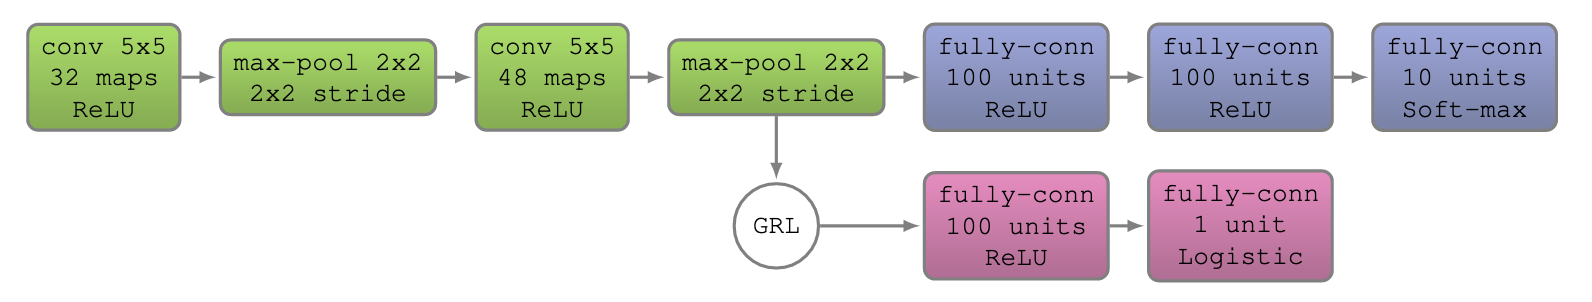

In [ ]:
class DANN(nn.Module):
    def __init__(self):
        super().__init__()  # Important, otherwise will throw an error

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),      # (32, 14, 14)
            nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2), # (48, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),      #  (48, 7, 7)
        )

        self.classif = nn.Sequential(
            nn.Linear(48 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            # Softmax included in the Cross-Entropy loss
        )

        self.domain = nn.Sequential(
            nn.Linear(48 * 7 * 7, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 1)
        )

    def forward(self, x, factor=1, grl = True):
        x = self.cnn(x)
        x = x.flatten(start_dim=1)

        class_pred = self.classif(x)

        # Question 1
        if grl:
          domain_pred = self.domain(GradientReversal.apply(x, -1 * factor))
        else:
          domain_pred = self.domain(x)

        return class_pred, domain_pred

In [ ]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [ ]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

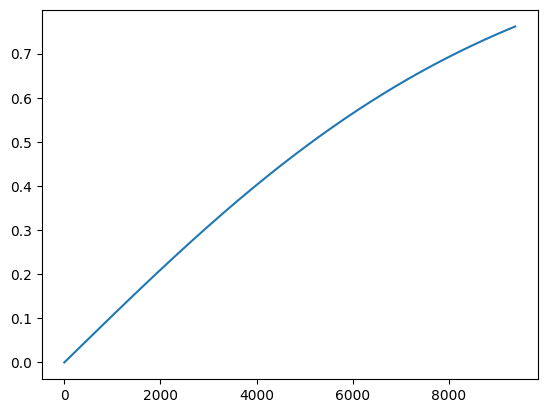

In [ ]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)

Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

#### Testing DANN without GRL Layer to see the effect.

**1. Using the DANN Architecture without the GRL part.**

In [ ]:
import torch
import math
from tqdm import tqdm

# Number of training epochs
epochs = 20

# Initialize the DANN model and move it to GPU
dann = DANN().cuda()

# Set up the optimizer with Stochastic Gradient Descent
optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

# Parameters for learning rate scheduling
mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)


# Training loop
for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.

    # Using tqdm for a progress bar
    progress_bar = tqdm(zip(source_train_loader, target_train_loader),
                        total=min(len(source_train_loader), len(target_train_loader)),
                        desc=f'Epoch {epoch+1}/{epochs}', leave=False)

    for (xs, ys), (xt, _) in progress_bar:
        grl_factor = lmbd(b)
        b += 1

        # Move data to GPU
        xs, ys = xs.cuda(), ys.cuda()
        xt = xt.cuda()

        # Concatenate source and target data
        x = torch.cat((xs, xt))

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through DANN
        cls_logits, domain_logits = dann(x, factor=1, grl= False)

        ce = F.cross_entropy(cls_logits[: len(ys)], ys)

        preds = torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
        bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], preds)

        # Sum the classification and domain losses
        loss = ce + bce
        loss.backward()
        optimizer.step()

        # Accumulate losses
        cls_loss += ce.item()
        domain_loss += bce.item()

        # Update progress bar with current losses
        progress_bar.set_postfix(class_loss=cls_loss, domain_loss=domain_loss)

    # Average the losses over the number of batches
    cls_loss /= len(source_train_loader)
    domain_loss /= (2 * len(source_train_loader))  # Factor of 2 accounts for combining source and target loaders

    # Print training results for the epoch
    print(f'Epoch {epoch+1}/{epochs} - Class Loss: {cls_loss:.5f}, Domain Loss: {domain_loss:.5f}')
    scheduler.step()

# Evaluation on source domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f'[SOURCE] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

# Evaluation on target domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f'[TARGET] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

Epoch 1/20 - Class Loss: 0.22356, Domain Loss: 0.01034


Epoch 2/20 - Class Loss: 0.04806, Domain Loss: 0.00070


Epoch 3/20 - Class Loss: 0.02865, Domain Loss: 0.00031


Epoch 4/20 - Class Loss: 0.02057, Domain Loss: 0.00018


Epoch 5/20 - Class Loss: 0.01542, Domain Loss: 0.00011


Epoch 6/20 - Class Loss: 0.01179, Domain Loss: 0.00008


Epoch 7/20 - Class Loss: 0.00944, Domain Loss: 0.00006


Epoch 8/20 - Class Loss: 0.00774, Domain Loss: 0.00006


Epoch 9/20 - Class Loss: 0.00634, Domain Loss: 0.00005


Epoch 10/20 - Class Loss: 0.00519, Domain Loss: 0.00003


Epoch 11/20 - Class Loss: 0.00431, Domain Loss: 0.00003


Epoch 12/20 - Class Loss: 0.00366, Domain Loss: 0.00002


Epoch 13/20 - Class Loss: 0.00312, Domain Loss: 0.00002


Epoch 14/20 - Class Loss: 0.00268, Domain Loss: 0.00002


Epoch 15/20 - Class Loss: 0.00234, Domain Loss: 0.00002


Epoch 16/20 - Class Loss: 0.00205, Domain Loss: 0.00002


Epoch 17/20 - Class Loss: 0.00183, Domain Loss: 0.00001


Epoch 18/20 - Class Loss: 0.00164, Domain Loss: 0.00001


Epoch 19/20 - Class Loss: 0.00148, Domain Loss: 0.00001


Epoch 20/20 - Class Loss: 0.00135, Domain Loss: 0.00001
[SOURCE] Class Accuracy: 99.14%, Domain Accuracy: 100.00% - Loss: Class 0.03646, Domain 0.00004
[TARGET] Class Accuracy: 41.79%, Domain Accuracy: 99.96% - Loss: Class 3.13455, Domain 0.00075


**Insights.**

- Without the Gradient Reversal Layer (GRL), the domain classifier became proficient at distinguishing between the source and target domains.

- This specialization would inadvertently train the feature extractor to emphasize domain-specific features.

- As a result, the neural network is be optimized for the source domain, achieving high accuracy there. However, this specialization  is counterproductive for domain adaptation, leading to poor performance on the target domain as the learned features would not generalize well.

- The absence of the GRL is thus defeating the purpose of domain adaptation, which is to learn domain-invariant features that perform equally well on both source and target domains.

#### Testing DANN Architecture with GRL Layer.

**DANN Architecture with GRL Layer.**

In [ ]:
import torch
import math
from tqdm import tqdm

# Number of training epochs
epochs = 20

# Initialize the DANN model and move it to GPU
dann = DANN().cuda()

# Set up the optimizer with Stochastic Gradient Descent
optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

# Parameters for learning rate scheduling
mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

# Lambda function to calculate the gradient reversal layer factor
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

# Initialize batch counter
b = 0

# Training loop
for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.

    # Update the GRL factor for the epoch
    grl_factor = lmbd(b)

    # Using tqdm for a progress bar
    progress_bar = tqdm(zip(source_train_loader, target_train_loader),
                        total=min(len(source_train_loader), len(target_train_loader)),
                        desc=f'Epoch {epoch+1}/{epochs}', leave=False)

    for (xs, ys), (xt, _) in progress_bar:
        grl_factor = lmbd(b)
        b += 1

        # Move data to GPU
        xs, ys = xs.cuda(), ys.cuda()
        xt = xt.cuda()

        # Concatenate source and target data
        x = torch.cat((xs, xt))

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through DANN
        cls_logits, domain_logits = dann(x, factor=grl_factor)

        ce = F.cross_entropy(cls_logits[: len(ys)], ys)

        preds = torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
        bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], preds)

        # Sum the classification and domain losses
        loss = ce + bce
        loss.backward()
        optimizer.step()

        # Accumulate losses
        cls_loss += ce.item()
        domain_loss += bce.item()

        # Update progress bar with current losses
        progress_bar.set_postfix(class_loss=cls_loss, domain_loss=domain_loss)

    # Average the losses over the number of batches
    cls_loss /= len(source_train_loader)
    domain_loss /= (2 * len(source_train_loader))  # Factor of 2 accounts for combining source and target loaders

    # Print training results for the epoch
    print(f'Epoch {epoch+1}/{epochs} - Class Loss: {cls_loss:.5f}, Domain Loss: {domain_loss:.5f}')
    print(f'GRL Factor: {grl_factor:.2f}')
    scheduler.step()

# Evaluation on source domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f'[SOURCE] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

# Evaluation on target domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f'[TARGET] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

Epoch 1/20 - Class Loss: 0.24918, Domain Loss: 0.04559
GRL Factor: 0.05


Epoch 2/20 - Class Loss: 0.04939, Domain Loss: 0.06420
GRL Factor: 0.10


Epoch 3/20 - Class Loss: 0.03281, Domain Loss: 0.07611
GRL Factor: 0.15


Epoch 4/20 - Class Loss: 0.02617, Domain Loss: 0.09623
GRL Factor: 0.20


Epoch 5/20 - Class Loss: 0.02330, Domain Loss: 0.10215
GRL Factor: 0.24


Epoch 6/20 - Class Loss: 0.02559, Domain Loss: 0.12541
GRL Factor: 0.29


Epoch 7/20 - Class Loss: 0.03048, Domain Loss: 0.15346
GRL Factor: 0.34


Epoch 8/20 - Class Loss: 0.03716, Domain Loss: 0.18678
GRL Factor: 0.38


Epoch 9/20 - Class Loss: 0.05040, Domain Loss: 0.22937
GRL Factor: 0.42


Epoch 10/20 - Class Loss: 0.05068, Domain Loss: 0.25586
GRL Factor: 0.46


Epoch 11/20 - Class Loss: 0.04723, Domain Loss: 0.27253
GRL Factor: 0.50


Epoch 12/20 - Class Loss: 0.03505, Domain Loss: 0.25504
GRL Factor: 0.54


Epoch 13/20 - Class Loss: 0.03184, Domain Loss: 0.25544
GRL Factor: 0.57


Epoch 14/20 - Class Loss: 0.02776, Domain Loss: 0.25847
GRL Factor: 0.60


Epoch 15/20 - Class Loss: 0.02685, Domain Loss: 0.26648
GRL Factor: 0.64


Epoch 16/20 - Class Loss: 0.02811, Domain Loss: 0.27162
GRL Factor: 0.66


Epoch 17/20 - Class Loss: 0.02826, Domain Loss: 0.27345
GRL Factor: 0.69


Epoch 18/20 - Class Loss: 0.03070, Domain Loss: 0.27857
GRL Factor: 0.72


Epoch 19/20 - Class Loss: 0.02683, Domain Loss: 0.28203
GRL Factor: 0.74


Epoch 20/20 - Class Loss: 0.07412, Domain Loss: 0.29157
GRL Factor: 0.76
[SOURCE] Class Accuracy: 98.42%, Domain Accuracy: 80.54% - Loss: Class 0.05069, Domain 0.51769
[TARGET] Class Accuracy: 73.56%, Domain Accuracy: 75.24% - Loss: Class 1.13811, Domain 0.45681


We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

#### Visualization with TSNE.

In [ ]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [ ]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

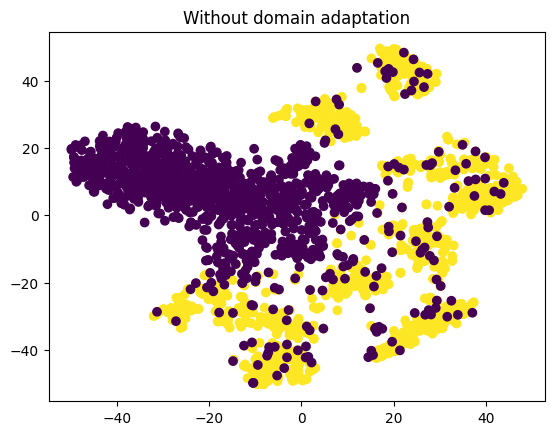

In [ ]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

**Use Of DANN Architecture without GRL Layer.**

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

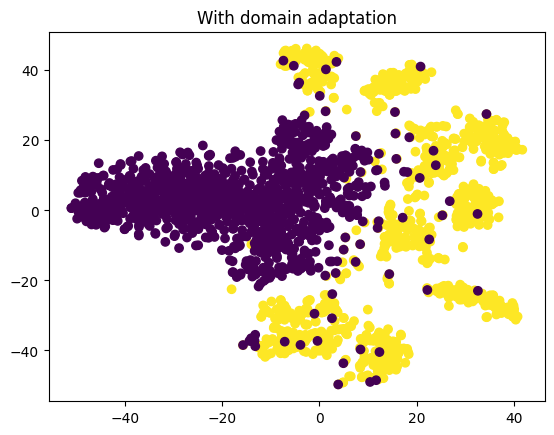

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

**Use Of DANN Architecture with GRL Layer.**

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

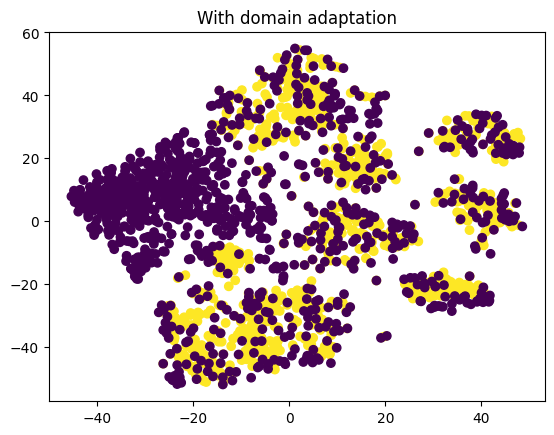

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

#### 3. The effect of the value of the negative number used to reverse the gradient in the GRL.

**a. Fonctions Linéaires.**

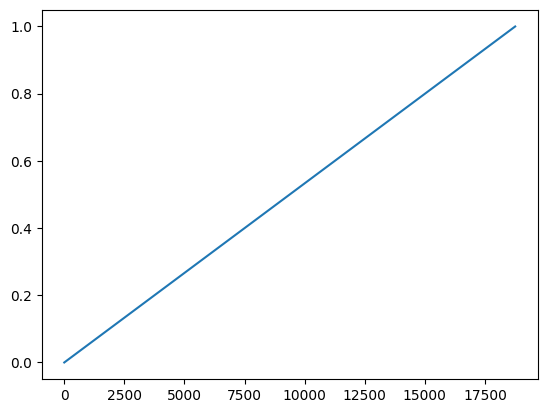

In [ ]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: max(0, e / (len(source_train_loader) * epochs)) ## croissance linéaire
y = [lmbd(i) for i in x]

plt.plot(x, y)

In [ ]:
import torch
import math
from tqdm import tqdm

# Number of training epochs
epochs = 20

# Initialize the DANN model and move it to GPU
dann = DANN().cuda()

# Set up the optimizer with Stochastic Gradient Descent
optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

# Parameters for learning rate scheduling
mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

# Lambda function to calculate the gradient reversal layer factor
lmbd = lambda e: max(0, e / (len(source_train_loader) * epochs)) ## croissance linéaire

# Initialize batch counter
b = 0

# Training loop
for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.

    # Update the GRL factor for the epoch
    grl_factor = lmbd(b)

    # Using tqdm for a progress bar
    progress_bar = tqdm(zip(source_train_loader, target_train_loader),
                        total=min(len(source_train_loader), len(target_train_loader)),
                        desc=f'Epoch {epoch+1}/{epochs}', leave=False)

    for (xs, ys), (xt, _) in progress_bar:
        grl_factor = lmbd(b)
        b += 1

        # Move data to GPU
        xs, ys = xs.cuda(), ys.cuda()
        xt = xt.cuda()

        # Concatenate source and target data
        x = torch.cat((xs, xt))

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through DANN
        cls_logits, domain_logits = dann(x, factor=grl_factor)

        ce = F.cross_entropy(cls_logits[: len(ys)], ys)

        preds = torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
        bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], preds)

        # Sum the classification and domain losses
        loss = ce + bce
        loss.backward()
        optimizer.step()

        # Accumulate losses
        cls_loss += ce.item()
        domain_loss += bce.item()

        # Update progress bar with current losses
        progress_bar.set_postfix(class_loss=cls_loss, domain_loss=domain_loss)

    # Average the losses over the number of batches
    cls_loss /= len(source_train_loader)
    domain_loss /= (2 * len(source_train_loader))  # Factor of 2 accounts for combining source and target loaders

    # Print training results for the epoch
    print(f'Epoch {epoch+1}/{epochs} - Class Loss: {cls_loss:.5f}, Domain Loss: {domain_loss:.5f}')
    print(f'GRL Factor: {grl_factor:.2f}')
    scheduler.step()

# Evaluation on source domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f'[SOURCE] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

# Evaluation on target domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f'[TARGET] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

Epoch 1/20 - Class Loss: 0.22946, Domain Loss: 0.04474
GRL Factor: 0.05


Epoch 2/20 - Class Loss: 0.04717, Domain Loss: 0.05156
GRL Factor: 0.10


Epoch 3/20 - Class Loss: 0.03013, Domain Loss: 0.07135
GRL Factor: 0.15


Epoch 4/20 - Class Loss: 0.02459, Domain Loss: 0.09090
GRL Factor: 0.20


Epoch 5/20 - Class Loss: 0.02237, Domain Loss: 0.10482
GRL Factor: 0.25


Epoch 6/20 - Class Loss: 0.02444, Domain Loss: 0.12406
GRL Factor: 0.30


Epoch 7/20 - Class Loss: 0.05308, Domain Loss: 0.12850
GRL Factor: 0.35


Epoch 8/20 - Class Loss: 0.02796, Domain Loss: 0.14853
GRL Factor: 0.40


Epoch 9/20 - Class Loss: 0.03579, Domain Loss: 0.16775
GRL Factor: 0.45


Epoch 10/20 - Class Loss: 0.04502, Domain Loss: 0.20555
GRL Factor: 0.50


Epoch 11/20 - Class Loss: 0.07626, Domain Loss: 0.24189
GRL Factor: 0.55


Epoch 12/20 - Class Loss: 0.05845, Domain Loss: 0.23528
GRL Factor: 0.60


Epoch 13/20 - Class Loss: 0.05660, Domain Loss: 0.27855
GRL Factor: 0.65


Epoch 14/20 - Class Loss: 0.03716, Domain Loss: 0.25937
GRL Factor: 0.70


Epoch 15/20 - Class Loss: 0.03071, Domain Loss: 0.26718
GRL Factor: 0.75


Epoch 16/20 - Class Loss: 0.02821, Domain Loss: 0.27892
GRL Factor: 0.80


Epoch 17/20 - Class Loss: 0.02869, Domain Loss: 0.27696
GRL Factor: 0.85


Epoch 18/20 - Class Loss: 0.03711, Domain Loss: 0.29707
GRL Factor: 0.90


Epoch 19/20 - Class Loss: 0.04851, Domain Loss: 0.26840
GRL Factor: 0.95


Epoch 20/20 - Class Loss: 0.04023, Domain Loss: 0.25972
GRL Factor: 1.00
[SOURCE] Class Accuracy: 98.44%, Domain Accuracy: 96.09% - Loss: Class 0.05772, Domain 0.15791
[TARGET] Class Accuracy: 71.72%, Domain Accuracy: 69.77% - Loss: Class 1.24355, Domain 0.67317


Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

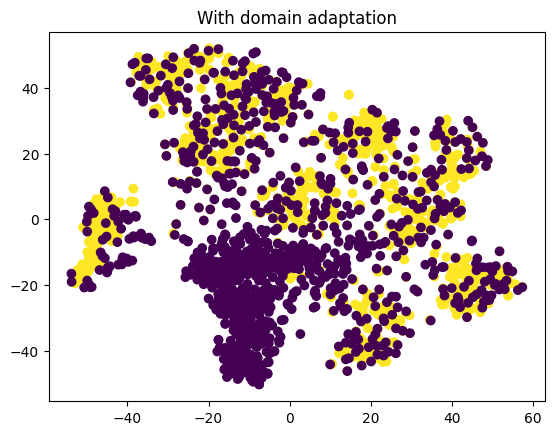

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

**b. Fonctions trigonométriques.**

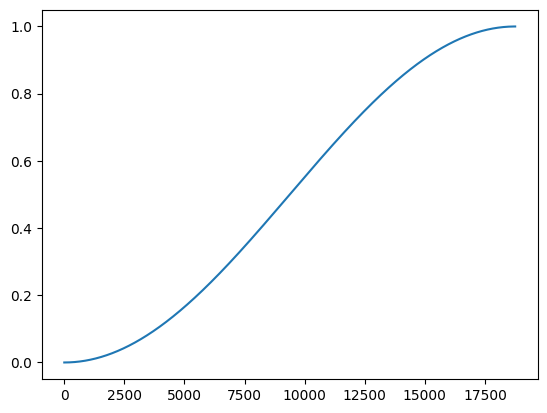

In [ ]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: 0.5 * (1 - math.cos(math.pi * e / (len(source_train_loader) * epochs))) #fonction trigonométrique
y = [lmbd(i) for i in x]

plt.plot(x, y)

In [ ]:
import torch
import math
from tqdm import tqdm

# Number of training epochs
epochs = 20

# Initialize the DANN model and move it to GPU
dann = DANN().cuda()

# Set up the optimizer with Stochastic Gradient Descent
optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

# Parameters for learning rate scheduling
mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

# Lambda function to calculate the gradient reversal layer factor
lmbd = lambda e: 0.5 * (1 - math.cos(math.pi * e / (len(source_train_loader) * epochs)))

# Initialize batch counter
b = 0

# Training loop
for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.

    # Update the GRL factor for the epoch
    grl_factor = lmbd(b)

    # Using tqdm for a progress bar
    progress_bar = tqdm(zip(source_train_loader, target_train_loader),
                        total=min(len(source_train_loader), len(target_train_loader)),
                        desc=f'Epoch {epoch+1}/{epochs}', leave=False)

    for (xs, ys), (xt, _) in progress_bar:
        grl_factor = lmbd(b)
        b += 1

        # Move data to GPU
        xs, ys = xs.cuda(), ys.cuda()
        xt = xt.cuda()

        # Concatenate source and target data
        x = torch.cat((xs, xt))

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through DANN
        cls_logits, domain_logits = dann(x, factor=grl_factor)

        ce = F.cross_entropy(cls_logits[: len(ys)], ys)

        preds = torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
        bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], preds)

        # Sum the classification and domain losses
        loss = ce + bce
        loss.backward()
        optimizer.step()

        # Accumulate losses
        cls_loss += ce.item()
        domain_loss += bce.item()

        # Update progress bar with current losses
        progress_bar.set_postfix(class_loss=cls_loss, domain_loss=domain_loss)

    # Average the losses over the number of batches
    cls_loss /= len(source_train_loader)
    domain_loss /= (2 * len(source_train_loader))  # Factor of 2 accounts for combining source and target loaders

    # Print training results for the epoch
    print(f'Epoch {epoch+1}/{epochs} - Class Loss: {cls_loss:.5f}, Domain Loss: {domain_loss:.5f}')
    print(f'GRL Factor: {grl_factor:.2f}')
    scheduler.step()

# Evaluation on source domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f'[SOURCE] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

# Evaluation on target domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f'[TARGET] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

Epoch 1/20 - Class Loss: 0.23982, Domain Loss: 0.03939
GRL Factor: 0.01


Epoch 2/20 - Class Loss: 0.04589, Domain Loss: 0.01154
GRL Factor: 0.02


Epoch 3/20 - Class Loss: 0.02788, Domain Loss: 0.02248
GRL Factor: 0.05


Epoch 4/20 - Class Loss: 0.02078, Domain Loss: 0.04173
GRL Factor: 0.10


Epoch 5/20 - Class Loss: 0.01741, Domain Loss: 0.06686
GRL Factor: 0.15


Epoch 6/20 - Class Loss: 0.01612, Domain Loss: 0.08468
GRL Factor: 0.21


Epoch 7/20 - Class Loss: 0.01510, Domain Loss: 0.09283
GRL Factor: 0.27


Epoch 8/20 - Class Loss: 0.02016, Domain Loss: 0.10873
GRL Factor: 0.35


Epoch 9/20 - Class Loss: 0.02881, Domain Loss: 0.12973
GRL Factor: 0.42


Epoch 10/20 - Class Loss: 0.03412, Domain Loss: 0.14931
GRL Factor: 0.50


Epoch 11/20 - Class Loss: 0.05794, Domain Loss: 0.19844
GRL Factor: 0.58


Epoch 12/20 - Class Loss: 0.09949, Domain Loss: 0.20480
GRL Factor: 0.65


Epoch 13/20 - Class Loss: 0.06974, Domain Loss: 0.24069
GRL Factor: 0.73


Epoch 14/20 - Class Loss: 0.22851, Domain Loss: 0.22685
GRL Factor: 0.79


Epoch 15/20 - Class Loss: 0.06596, Domain Loss: 0.26649
GRL Factor: 0.85


Epoch 16/20 - Class Loss: 0.06277, Domain Loss: 0.27194
GRL Factor: 0.90


Epoch 17/20 - Class Loss: 0.04258, Domain Loss: 0.27347
GRL Factor: 0.95


Epoch 18/20 - Class Loss: 0.03503, Domain Loss: 0.26244
GRL Factor: 0.98


Epoch 19/20 - Class Loss: 0.05045, Domain Loss: 0.26766
GRL Factor: 0.99


Epoch 20/20 - Class Loss: 0.03588, Domain Loss: 0.27424
GRL Factor: 1.00
[SOURCE] Class Accuracy: 98.49%, Domain Accuracy: 82.43% - Loss: Class 0.05077, Domain 0.49861
[TARGET] Class Accuracy: 73.85%, Domain Accuracy: 62.70% - Loss: Class 1.00876, Domain 0.59677


Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

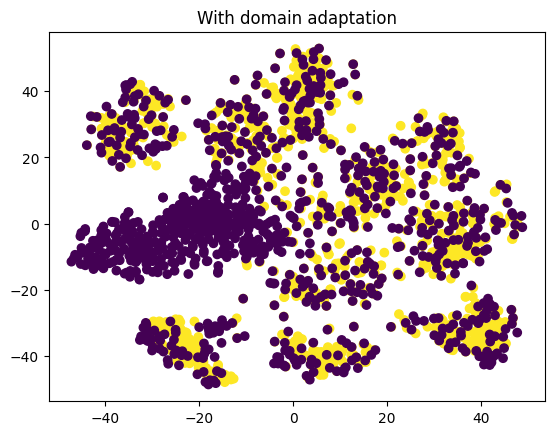

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

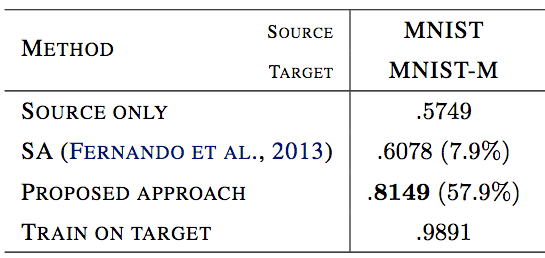

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling

### Going Further.

Now we will try to improve our performance and get near the results reported in the original paper.

**Use of more epochs.**

In [ ]:
import torch
import math
from tqdm import tqdm

# Number of training epochs
epochs = 50

# Initialize the DANN model and move it to GPU
dann = DANN().cuda()

# Set up the optimizer with Stochastic Gradient Descent
optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

# Parameters for learning rate scheduling
mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

# Lambda function to calculate the gradient reversal layer factor
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

# Initialize batch counter
b = 0

# Training loop
for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.

    # Update the GRL factor for the epoch
    grl_factor = lmbd(b)

    # Using tqdm for a progress bar
    progress_bar = tqdm(zip(source_train_loader, target_train_loader),
                        total=min(len(source_train_loader), len(target_train_loader)),
                        desc=f'Epoch {epoch+1}/{epochs}', leave=False)

    for (xs, ys), (xt, _) in progress_bar:
        grl_factor = lmbd(b)
        b += 1

        # Move data to GPU
        xs, ys = xs.cuda(), ys.cuda()
        xt = xt.cuda()

        # Concatenate source and target data
        x = torch.cat((xs, xt))

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through DANN
        cls_logits, domain_logits = dann(x, factor=grl_factor)

        ce = F.cross_entropy(cls_logits[: len(ys)], ys)

        preds = torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
        bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], preds)

        # Sum the classification and domain losses
        loss = ce + bce
        loss.backward()
        optimizer.step()

        # Accumulate losses
        cls_loss += ce.item()
        domain_loss += bce.item()

        # Update progress bar with current losses
        progress_bar.set_postfix(class_loss=cls_loss, domain_loss=domain_loss)

    # Average the losses over the number of batches
    cls_loss /= len(source_train_loader)
    domain_loss /= (2 * len(source_train_loader))  # Factor of 2 accounts for combining source and target loaders

    # Print training results for the epoch
    print(f'Epoch {epoch+1}/{epochs} - Class Loss: {cls_loss:.5f}, Domain Loss: {domain_loss:.5f}')
    print(f'GRL Factor: {grl_factor:.2f}')
    scheduler.step()

# Evaluation on source domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f'[SOURCE] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

# Evaluation on target domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f'[TARGET] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

Epoch 1/50 - Class Loss: 0.22869, Domain Loss: 0.03515
GRL Factor: 0.02


Epoch 2/50 - Class Loss: 0.04909, Domain Loss: 0.03593
GRL Factor: 0.04


Epoch 3/50 - Class Loss: 0.03045, Domain Loss: 0.03337
GRL Factor: 0.06


Epoch 4/50 - Class Loss: 0.02093, Domain Loss: 0.04897
GRL Factor: 0.08


Epoch 5/50 - Class Loss: 0.01603, Domain Loss: 0.05730
GRL Factor: 0.10


Epoch 6/50 - Class Loss: 0.01280, Domain Loss: 0.06435
GRL Factor: 0.12


Epoch 7/50 - Class Loss: 0.01086, Domain Loss: 0.07027
GRL Factor: 0.14


Epoch 8/50 - Class Loss: 0.01001, Domain Loss: 0.07778
GRL Factor: 0.16


Epoch 9/50 - Class Loss: 0.01098, Domain Loss: 0.09396
GRL Factor: 0.18


Epoch 10/50 - Class Loss: 0.01247, Domain Loss: 0.10942
GRL Factor: 0.20


Epoch 11/50 - Class Loss: 0.01722, Domain Loss: 0.13039
GRL Factor: 0.22


Epoch 12/50 - Class Loss: 0.02121, Domain Loss: 0.16426
GRL Factor: 0.24


Epoch 13/50 - Class Loss: 0.03142, Domain Loss: 0.18875
GRL Factor: 0.25


Epoch 14/50 - Class Loss: 0.02972, Domain Loss: 0.21740
GRL Factor: 0.27


Epoch 15/50 - Class Loss: 0.03271, Domain Loss: 0.22790
GRL Factor: 0.29


Epoch 16/50 - Class Loss: 0.02785, Domain Loss: 0.23675
GRL Factor: 0.31


Epoch 17/50 - Class Loss: 0.02300, Domain Loss: 0.24092
GRL Factor: 0.33


Epoch 18/50 - Class Loss: 0.01808, Domain Loss: 0.24809
GRL Factor: 0.35


Epoch 19/50 - Class Loss: 0.01635, Domain Loss: 0.25944
GRL Factor: 0.36


Epoch 20/50 - Class Loss: 0.01733, Domain Loss: 0.25206
GRL Factor: 0.38


Epoch 21/50 - Class Loss: 0.02536, Domain Loss: 0.26519
GRL Factor: 0.40


Epoch 22/50 - Class Loss: 0.01559, Domain Loss: 0.26255
GRL Factor: 0.41


Epoch 23/50 - Class Loss: 0.01337, Domain Loss: 0.27092
GRL Factor: 0.43


Epoch 24/50 - Class Loss: 0.01443, Domain Loss: 0.27256
GRL Factor: 0.45


Epoch 25/50 - Class Loss: 0.01282, Domain Loss: 0.27126
GRL Factor: 0.46


Epoch 26/50 - Class Loss: 0.01246, Domain Loss: 0.27373
GRL Factor: 0.48


Epoch 27/50 - Class Loss: 0.01198, Domain Loss: 0.27419
GRL Factor: 0.49


Epoch 28/50 - Class Loss: 0.01443, Domain Loss: 0.27503
GRL Factor: 0.51


Epoch 29/50 - Class Loss: 0.01629, Domain Loss: 0.27693
GRL Factor: 0.52


Epoch 30/50 - Class Loss: 0.01295, Domain Loss: 0.27750
GRL Factor: 0.54


Epoch 31/50 - Class Loss: 0.01437, Domain Loss: 0.27750
GRL Factor: 0.55


Epoch 32/50 - Class Loss: 0.01466, Domain Loss: 0.27627
GRL Factor: 0.56


Epoch 33/50 - Class Loss: 0.01300, Domain Loss: 0.27734
GRL Factor: 0.58


Epoch 34/50 - Class Loss: 0.01307, Domain Loss: 0.28235
GRL Factor: 0.59


Epoch 35/50 - Class Loss: 0.01155, Domain Loss: 0.27958
GRL Factor: 0.60


Epoch 36/50 - Class Loss: 0.01164, Domain Loss: 0.27987
GRL Factor: 0.62


Epoch 37/50 - Class Loss: 0.01126, Domain Loss: 0.27950
GRL Factor: 0.63


Epoch 38/50 - Class Loss: 0.01367, Domain Loss: 0.27937
GRL Factor: 0.64


Epoch 39/50 - Class Loss: 0.01282, Domain Loss: 0.28026
GRL Factor: 0.65


Epoch 40/50 - Class Loss: 0.01124, Domain Loss: 0.28022
GRL Factor: 0.66


Epoch 41/50 - Class Loss: 0.01290, Domain Loss: 0.28216
GRL Factor: 0.68


Epoch 42/50 - Class Loss: 0.01472, Domain Loss: 0.28315
GRL Factor: 0.69


Epoch 43/50 - Class Loss: 0.12983, Domain Loss: 0.28944
GRL Factor: 0.70


Epoch 44/50 - Class Loss: 0.03412, Domain Loss: 0.29168
GRL Factor: 0.71


Epoch 45/50 - Class Loss: 0.03853, Domain Loss: 0.26033
GRL Factor: 0.72


Epoch 46/50 - Class Loss: 0.02726, Domain Loss: 0.29486
GRL Factor: 0.73


Epoch 47/50 - Class Loss: 0.17755, Domain Loss: 0.33091
GRL Factor: 0.74


Epoch 48/50 - Class Loss: 0.16690, Domain Loss: 0.13038
GRL Factor: 0.74


Epoch 49/50 - Class Loss: 0.03532, Domain Loss: 0.21516
GRL Factor: 0.75


Epoch 50/50 - Class Loss: 0.02541, Domain Loss: 0.26859
GRL Factor: 0.76
[SOURCE] Class Accuracy: 98.59%, Domain Accuracy: 86.80% - Loss: Class 0.04704, Domain 0.42559
[TARGET] Class Accuracy: 76.52%, Domain Accuracy: 61.43% - Loss: Class 0.84860, Domain 0.61601


Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

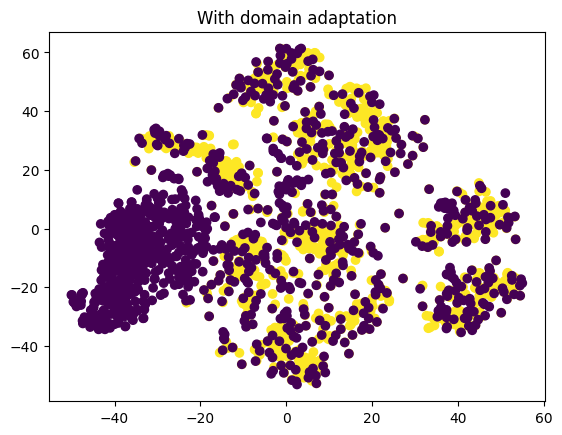

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

Using more epochs improves somehow the accuracy, but still not to the level of the original paper.

**Update the Learning Rate Scheduler Per Step.**

In [ ]:
import torch
import math
from tqdm import tqdm

# Number of training epochs
epochs = 20

# Initialize the DANN model and move it to GPU
dann = DANN().cuda()

# Set up the optimizer with Stochastic Gradient Descent
optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

# Parameters for learning rate scheduling
mu0, alpha, beta = 0.01, 10, 0.75

# Modify the learning rate scheduler to update per step
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: 0.01 / ((1 + alpha * step / (len(source_train_loader) * epochs)) ** beta)
)

# Lambda function to calculate the gradient reversal layer factor
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

# Initialize batch counter
b = 0

# Training loop
for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.

    # Update the GRL factor for the epoch
    grl_factor = lmbd(b)

    # Using tqdm for a progress bar
    progress_bar = tqdm(zip(source_train_loader, target_train_loader),
                        total=min(len(source_train_loader), len(target_train_loader)),
                        desc=f'Epoch {epoch+1}/{epochs}', leave=False)

    for (xs, ys), (xt, _) in progress_bar:
        grl_factor = lmbd(b)
        b += 1

        # Move data to GPU
        xs, ys = xs.cuda(), ys.cuda()
        xt = xt.cuda()

        # Concatenate source and target data
        x = torch.cat((xs, xt))

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through DANN
        cls_logits, domain_logits = dann(x, factor=grl_factor)

        ce = F.cross_entropy(cls_logits[: len(ys)], ys)

        preds = torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
        bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], preds)

        # Sum the classification and domain losses
        loss = ce + bce
        loss.backward()
        optimizer.step()

        # Accumulate losses
        cls_loss += ce.item()
        domain_loss += bce.item()

        # Update progress bar with current losses
        progress_bar.set_postfix(class_loss=cls_loss, domain_loss=domain_loss)

        # Update of learning rate per step
        scheduler.step()

    # Average the losses over the number of batches
    cls_loss /= len(source_train_loader)
    domain_loss /= (2 * len(source_train_loader))  # Factor of 2 accounts for combining source and target loaders

    # Print training results for the epoch
    print(f'Epoch {epoch+1}/{epochs} - Class Loss: {cls_loss:.5f}, Domain Loss: {domain_loss:.5f}')
    print(f'GRL Factor: {grl_factor:.2f}')

# Evaluation on source domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f'[SOURCE] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

# Evaluation on target domain test data
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f'[TARGET] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

Epoch 1/20 - Class Loss: 0.23204, Domain Loss: 0.05200
GRL Factor: 0.05


Epoch 2/20 - Class Loss: 0.04983, Domain Loss: 0.05770
GRL Factor: 0.10


Epoch 3/20 - Class Loss: 0.03279, Domain Loss: 0.07760
GRL Factor: 0.15


Epoch 4/20 - Class Loss: 0.02553, Domain Loss: 0.08704
GRL Factor: 0.20


Epoch 5/20 - Class Loss: 0.02373, Domain Loss: 0.09917
GRL Factor: 0.24


Epoch 6/20 - Class Loss: 0.02588, Domain Loss: 0.12558
GRL Factor: 0.29


Epoch 7/20 - Class Loss: 0.03062, Domain Loss: 0.15527
GRL Factor: 0.34


Epoch 8/20 - Class Loss: 0.04021, Domain Loss: 0.19279
GRL Factor: 0.38


Epoch 9/20 - Class Loss: 0.04691, Domain Loss: 0.22847
GRL Factor: 0.42


Epoch 10/20 - Class Loss: 0.04990, Domain Loss: 0.26481
GRL Factor: 0.46


Epoch 11/20 - Class Loss: 0.03748, Domain Loss: 0.26631
GRL Factor: 0.50


Epoch 12/20 - Class Loss: 0.02859, Domain Loss: 0.25620
GRL Factor: 0.54


Epoch 13/20 - Class Loss: 0.02862, Domain Loss: 0.26040
GRL Factor: 0.57


Epoch 14/20 - Class Loss: 0.02860, Domain Loss: 0.26826
GRL Factor: 0.60


Epoch 15/20 - Class Loss: 0.02500, Domain Loss: 0.26865
GRL Factor: 0.64


Epoch 16/20 - Class Loss: 0.03093, Domain Loss: 0.27432
GRL Factor: 0.66


Epoch 17/20 - Class Loss: 0.02942, Domain Loss: 0.27694
GRL Factor: 0.69


Epoch 18/20 - Class Loss: 0.02837, Domain Loss: 0.28298
GRL Factor: 0.72


Epoch 19/20 - Class Loss: 0.02945, Domain Loss: 0.28303
GRL Factor: 0.74


Epoch 20/20 - Class Loss: 0.03052, Domain Loss: 0.28938
GRL Factor: 0.76
[SOURCE] Class Accuracy: 97.21%, Domain Accuracy: 72.87% - Loss: Class 0.09873, Domain 0.63740
[TARGET] Class Accuracy: 71.83%, Domain Accuracy: 68.33% - Loss: Class 1.23247, Domain 0.48517


As we can see, updating the learning rate at each step doesn't improve the network's accuracy, it decreases instead !

**Test Different Standardizations.**

In [ ]:
standardizations = {
    'standard_1': (torch.tensor([0.5, 0.5, 0.5]), torch.tensor([0.5, 0.5, 0.5])),
    'standard_2': (torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])),
    'standard_3': (torch.tensor([0.1307,]), torch.tensor([0.3081,]))
    # Add more standardizations as needed
}

# Load the raw MNIST dataset
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255

In [ ]:
for name, (mean, std) in standardizations.items():
    # Define the transformation pipeline with the current standardization
    transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
        transforms.Normalize(mean, std)
    ])

    # Apply the transformation to the MNIST datasets
    mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
    mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

    source_train_loader = DataLoader(mnist_train, batch_size=128)
    source_test_loader = DataLoader(mnist_test, batch_size=128)

    # Assuming MNISTM is a custom dataset class for MNIST-M
    mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
    mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

    target_train_loader = DataLoader(mnistm_train, batch_size=128)
    target_test_loader = DataLoader(mnistm_test, batch_size=128)

    # Now, you can train and evaluate your model with each standardization
    # Number of training epochs
    epochs = 10

    # Initialize the DANN model and move it to GPU
    dann = DANN().cuda()

    # Set up the optimizer with Stochastic Gradient Descent
    optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

    # Parameters for learning rate scheduling
    mu0, alpha, beta = 0.01, 10, 0.75

    # Modify the learning rate scheduler to update per step
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: 0.01 / ((1 + alpha * step / (len(source_train_loader) * epochs)) ** beta)
    )

    # Lambda function to calculate the gradient reversal layer factor
    lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

    # Initialize batch counter
    b = 0

    # Training loop
    for epoch in range(epochs):
        cls_loss, domain_loss = 0., 0.

        # Update the GRL factor for the epoch
        grl_factor = lmbd(b)

        # Using tqdm for a progress bar
        progress_bar = tqdm(zip(source_train_loader, target_train_loader),
                            total=min(len(source_train_loader), len(target_train_loader)),
                            desc=f'Epoch {epoch+1}/{epochs}', leave=False)

        for (xs, ys), (xt, _) in progress_bar:
            grl_factor = lmbd(b)
            b += 1

            # Move data to GPU
            xs, ys = xs.cuda(), ys.cuda()
            xt = xt.cuda()

            # Concatenate source and target data
            x = torch.cat((xs, xt))

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass through DANN
            cls_logits, domain_logits = dann(x, factor=grl_factor)

            ce = F.cross_entropy(cls_logits[: len(ys)], ys)

            preds = torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
            bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], preds)

            # Sum the classification and domain losses
            loss = ce + bce
            loss.backward()
            optimizer.step()

            # Accumulate losses
            cls_loss += ce.item()
            domain_loss += bce.item()

            # Update progress bar with current losses
            progress_bar.set_postfix(class_loss=cls_loss, domain_loss=domain_loss)

            # Update of learning rate per step
            scheduler.step()

        # Average the losses over the number of batches
        cls_loss /= len(source_train_loader)
        domain_loss /= (2 * len(source_train_loader))  # Factor of 2 accounts for combining source and target loaders

        # Print training results for the epoch
        print(f'Epoch {epoch+1}/{epochs} - Class Loss: {cls_loss:.5f}, Domain Loss: {domain_loss:.5f}')
        print(f'GRL Factor: {grl_factor:.2f}')

    # Evaluation on source domain test data
    c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
    print(f'[SOURCE] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

    # Evaluation on target domain test data
    c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
    print(f'[TARGET] Class Accuracy: {c_acc:.2f}%, Domain Accuracy: {d_acc:.2f}% - Loss: Class {c_loss:.5f}, Domain {d_loss:.5f}')

    print("----------")

Epoch 1/10 - Class Loss: 0.49227, Domain Loss: 0.11950
GRL Factor: 0.10


Epoch 2/10 - Class Loss: 0.07740, Domain Loss: 0.08758
GRL Factor: 0.20


Epoch 3/10 - Class Loss: 0.06212, Domain Loss: 0.11270
GRL Factor: 0.29


Epoch 4/10 - Class Loss: 0.05204, Domain Loss: 0.09776
GRL Factor: 0.38


Epoch 5/10 - Class Loss: 0.05869, Domain Loss: 0.10578
GRL Factor: 0.46


Epoch 6/10 - Class Loss: 0.05083, Domain Loss: 0.11003
GRL Factor: 0.54


Epoch 7/10 - Class Loss: 0.04772, Domain Loss: 0.11630
GRL Factor: 0.60


Epoch 8/10 - Class Loss: 0.04927, Domain Loss: 0.14066
GRL Factor: 0.66


Epoch 9/10 - Class Loss: 0.05891, Domain Loss: 0.15130
GRL Factor: 0.72


Epoch 10/10 - Class Loss: 0.06859, Domain Loss: 0.18132
GRL Factor: 0.76
[SOURCE] Class Accuracy: 98.15%, Domain Accuracy: 83.28% - Loss: Class 0.07261, Domain 0.36821
[TARGET] Class Accuracy: 64.80%, Domain Accuracy: 81.23% - Loss: Class 1.69714, Domain 0.40243
----------


Epoch 1/10 - Class Loss: 0.33195, Domain Loss: 0.09636
GRL Factor: 0.10


Epoch 2/10 - Class Loss: 0.06201, Domain Loss: 0.08500
GRL Factor: 0.20


Epoch 3/10 - Class Loss: 0.05016, Domain Loss: 0.10119
GRL Factor: 0.29


Epoch 4/10 - Class Loss: 0.04261, Domain Loss: 0.11144
GRL Factor: 0.38


Epoch 5/10 - Class Loss: 0.03903, Domain Loss: 0.13150
GRL Factor: 0.46


Epoch 6/10 - Class Loss: 0.04202, Domain Loss: 0.14733
GRL Factor: 0.54


Epoch 7/10 - Class Loss: 0.04878, Domain Loss: 0.16060
GRL Factor: 0.60


Epoch 8/10 - Class Loss: 0.09224, Domain Loss: 0.17529
GRL Factor: 0.66


Epoch 9/10 - Class Loss: 0.04966, Domain Loss: 0.17270
GRL Factor: 0.72


Epoch 10/10 - Class Loss: 0.05765, Domain Loss: 0.20257
GRL Factor: 0.76
[SOURCE] Class Accuracy: 98.18%, Domain Accuracy: 72.09% - Loss: Class 0.05375, Domain 0.55695
[TARGET] Class Accuracy: 63.62%, Domain Accuracy: 90.32% - Loss: Class 1.67118, Domain 0.21157
----------


Epoch 1/10 - Class Loss: 0.42750, Domain Loss: 0.07241
GRL Factor: 0.10


Epoch 2/10 - Class Loss: 0.07593, Domain Loss: 0.04082
GRL Factor: 0.20


Epoch 3/10 - Class Loss: 0.05919, Domain Loss: 0.07552
GRL Factor: 0.29


Epoch 4/10 - Class Loss: 0.05021, Domain Loss: 0.09594
GRL Factor: 0.38


Epoch 5/10 - Class Loss: 0.04453, Domain Loss: 0.11750
GRL Factor: 0.46


Epoch 6/10 - Class Loss: 0.04405, Domain Loss: 0.12520
GRL Factor: 0.54


Epoch 7/10 - Class Loss: 0.04220, Domain Loss: 0.13111
GRL Factor: 0.60


Epoch 8/10 - Class Loss: 0.04332, Domain Loss: 0.14622
GRL Factor: 0.66


Epoch 9/10 - Class Loss: 0.04947, Domain Loss: 0.16816
GRL Factor: 0.72


Epoch 10/10 - Class Loss: 0.06527, Domain Loss: 0.20055
GRL Factor: 0.76
[SOURCE] Class Accuracy: 97.54%, Domain Accuracy: 94.67% - Loss: Class 0.07243, Domain 0.14385
[TARGET] Class Accuracy: 55.90%, Domain Accuracy: 92.42% - Loss: Class 2.51671, Domain 0.24544
----------


The different techniques used do not improve the results, and the paper results are still better, maybe using other techniques or trying to combine them will do the job.